# emissions_bug_draft2017a.ipynb

## Purpose
1. Investigate impact of bug in aitkin-mode primary sulfate emissions.
2. Produce additional supplementary figures for *"Background Conditions Influence the Cloud Radiative Effects of Anthropogenic Aerosol Emissions from Different Source Regions"*, complementing [figures_draft2017a.ipynb](https://github.com/grandey/draft2017a-region-rfp/blob/master/figures_draft2017a.ipynb).

## Background
### What should have happened ("intended", as per scenario *"Correct1"*)
2.5% of the sulfur dioxide emissions should be emitted as primary sulfate (Dentener et al., 2006; Liu et al., 2012), with the mode ("a1"=accumulation or "a2"=aitkin) and the vertical distribution ("surf"=surface or "elev"=elevated) depending on the source sector:
- energy, industry, and wildfire -> accumulation-mode (a1), elevated
- shipping, waste treatment, and agricultural waste burning -> accumulation-mode (a1), surface
- continuous volcanic -> aitkin-mode (a2), elevated
- domestic, and transport -> aitkin-mode (a2), surface.

The size distributions should follow the size distributions described in the Supplement of Liu et al. (2012).

### What actually happened ("actual", as per scenario *"All1"* and the *“Θ1”* / *“Θ0”* groups of scenarios)
The user_nl_cam files for the simulations contained a bug: the line specifying the primary sulfate aitkin-mode (a2) surface emissions incorrectly pointed to the corresponding accumulation-mode (a1) surface emissions file.  This has three consequences:
1. The **domestic** and **transport** sector primary sulfate emissions are **missing** from the simulations. This leads to a slight **decrease** in sulfur emissions over **land** in *All1* and *Ship0* and over specific land regions in the *Θ1* group (excluding *Ship1*).
2. The **shipping**, **waste treatment**, and **agricultural waste burning** primary sulfate emissions are twice what they should be, with 1x emitted in the accumulation-mode (correct) and 1x emitted in the aitkin-mode (error). The impact on shipping emissions is most evident. This leads to a slight **increase** in sulfur emissions over **ocean** in *All1*, *Ship1*, and the *Θ0* group (excluding *Ship0*).
3. The erroneous **aitkin-mode surface emissions** have **incorrect size distributions**, since the aitkin-mode surface number emissions still follow the domestic and transort sector number emissions.

It should be noted that the simulations are still consistent with the intended scenarios (e.g. *Ship0* still contains no shipping emissions).

### Investigating the impact of erroneous aitkin-mode primary sulfate emissions
In order to test the sensitivity of the results to the emissions bug, an additional simulation, using the correct "intended" emissions, has been performed: *p17b_F_Hist_2000* (referred to as *"Correct1"* in the manuscript). The results of *p17b_F_Hist_2000* (*"Correct1"*) are compared to those of *p16a_F_Hist_2000* (*"All1"*).

### Consequences
At any given location, the error in the total sulfur emissions is never greater than 2.5%, and is generally much less than this.
Since the aitkin-mode primary sulfate emissions represent only a small percentage of the total sulfur emissions, it is expected that this bug will have minimal impact on the radiative effects.
This assertion that the bug has little impact on the radiative effects is backed up by two lines of evidence:
1. When one looks at the bar charts produced by [figures_draft2017a.ipynb](https://github.com/grandey/draft2017a-region-rfp/blob/master/figures_draft2017a.ipynb), it can be seen that the error bars for *Correct1*-*All0* and *All1*-*All0* always overlap - there is no statistically significant difference between the *Correct1* and *All1* global/regional results presented in these bar charts.
2. When one looks at maps of the differences between *Correct1* and *All1* (see below), the differences are insignificant almost everywhere.

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2017a.py](https://github.com/grandey/draft2017a-region-rfp/blob/master/lib_draft2017a.py) 

## Data requirements
CESM output data, post-processed to time-series format, as described in [data_management.org](https://github.com/grandey/draft2017a-region-rfp/blob/master/data_management.org#syncing-to-local-machine-for-analysis). These data will also be uploaded to figshare.

## Author
Benjamin S. Grandey, 2017-2018.

In [1]:
! date

Wed Aug 15 17:19:39 +08 2018


In [2]:
# Custom packages/modules
import lib_draft2017a
import climapy

# Standard packages/modules
import IPython
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from scipy import stats
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2017a.py is using {}'.format(lib_draft2017a.dependency_versions()))

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.14.3
pandas.__version__ = 0.23.0
xarray.__version__ = 0.10.4
lib_draft2017a.py is using {'climapy': '0.1.0+b35937c', 'numpy': '1.14.3', 'pandas': '0.23.0', 'xarray': '0.10.4'}


In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures

In [4]:
# Directory in which to save figures
fig_dir = 'local/'
# Initialise counters to keep track of figure numbers
supp_figure_counter = 13
# Note: supplementary figures S1-S12 are produced by figures_draft2017a.ipynb

## Impact of bug on sulfur emissions

### Table showing global primary sulfate emissions for each mode and level (for All1 / Correct1)

In [5]:
# Get Correct1 (ie intended) emissions
sulfate_dict = {}  # dictionary to hold global totals
scenario = 'Hist_2000'
for aer_mode in ['so4_a1', 'so4_a2']:  # accumulation mode or Aitken mode
    for surf_or_elev in ['surf', 'elev']:
        data = lib_draft2017a.load_emissions(aer_mode, surf_or_elev, scenario=scenario)
        data_sum = float(climapy.xr_area_weighted_stat(data, stat='sum')) / 1e12  # Tg(S)/yr
        sulfate_dict['{}_{}'.format(aer_mode, surf_or_elev)] = data_sum
# Dictionary containing emissions sources
source_dict = {'so4_a1_surf': 'shipping, waste treatment, agricultural waste burning',
               'so4_a1_elev': 'energy, industry, wildfire',
               'so4_a2_surf': 'domestic, transport',
               'so4_a2_elev': 'continuous volcanic'}
# Populate DataFrame
sulfate_df = pd.DataFrame(columns=['Intended sources',
                                    'Actual sources used',
                                    'Intended emissions,<br>Tg(S) yr$^{-1}$',
                                    'Actual emissions used,<br>Tg(S) yr$^{-1}$',
                                    'Error (actual - intended),<br>Tg(S) yr$^{-1}$'])
for aer_mode, aer_mode_long in zip(['so4_a1', 'so4_a2'],
                                   ['Accumulation mode', 'Aitken mode']):
    for surf_or_elev, surf_or_elev_long in zip(['surf', 'elev'],
                                               ['surface', 'elevated']):
        intended = sulfate_dict['{}_{}'.format(aer_mode, surf_or_elev)]
        intended_sources = source_dict['{}_{}'.format(aer_mode, surf_or_elev)]
        if aer_mode == 'so4_a2' and surf_or_elev == 'surf':
            actual = sulfate_dict['so4_a1_surf']
            actual_sources = source_dict['so4_a1_surf']
        else:
            actual = intended
            actual_sources = intended_sources
        error = actual - intended
        sulfate_df = sulfate_df.append(
                pd.Series({'Intended sources': intended_sources,
                           'Actual sources used': actual_sources,
                           'Intended emissions,<br>Tg(S) yr$^{-1}$': intended,
                           'Actual emissions used,<br>Tg(S) yr$^{-1}$': actual,
                           'Error (actual - intended),<br>Tg(S) yr$^{-1}$': error},
                name='{}, {}'.format(aer_mode_long, surf_or_elev_long)))
sulfate_df

,Intended sources,Actual sources used,"Intended emissions,<br>Tg(S) yr$^{-1}$","Actual emissions used,<br>Tg(S) yr$^{-1}$","Error (actual - intended),<br>Tg(S) yr$^{-1}$"
"Accumulation mode, surface","shipping, waste treatment, agricultural waste ...","shipping, waste treatment, agricultural waste ...",0.141687,0.141687,0.000000
"Accumulation mode, elevated","energy, industry, wildfire","energy, industry, wildfire",1.203976,1.203976,0.000000
"Aitken mode, surface","domestic, transport","shipping, waste treatment, agricultural waste ...",0.157088,0.141687,-0.015401
"Aitken mode, elevated",continuous volcanic,continuous volcanic,0.157489,0.157489,0.000000


In [6]:
# Prepare styled table
sulfate_styler = sulfate_df.style\
    .set_table_styles([{'selector': "th",  # header alignment
                        'props': [("text-align", "center")]},
                      {'selector': 'caption',  # caption properties
                       'props': [('text-align', 'center'),
                                 ('font-size', '150%')]}])\
    .set_caption('Global primary sulfate emissions for scenario All1')\
    .format({'Intended emissions,<br>Tg(S) yr$^{-1}$': '{:.3f}',
             'Actual emissions used,<br>Tg(S) yr$^{-1}$': '{:.3f}',
             'Error (actual - intended),<br>Tg(S) yr$^{-1}$': '{:.3f}'})\
    .set_properties(**{'text-align': 'center', 'width': '4.2cm'})
# Render to HTML and manually highlight specific cells
sulfate_render = sulfate_styler.render()
for cell in ['row2_col1', 'row2_col3', 'row2_col4']:
    sulfate_render = sulfate_render.replace(
            '{}'.format(cell) + ' {\n',
            '{}'.format(cell) + ' {\n            background-color:  yellow;\n')
# Display the table - and print reminder to take a screenshot
# Note: may not be properly rendered when viewed on GitHub
print('Take a screenshot and rename the file to fS{:02}.png'.format(supp_figure_counter))
supp_figure_counter += 1
IPython.display.HTML(sulfate_render)

Take a screenshot and rename the file to fS13.png


,Intended sources,Actual sources used,"Intended emissions,Tg(S) yr$^{-1}$","Actual emissions used,Tg(S) yr$^{-1}$","Error (actual - intended),Tg(S) yr$^{-1}$"
"Accumulation mode, surface","shipping, waste treatment, agricultural waste burning","shipping, waste treatment, agricultural waste burning",0.142,0.142,0.000
"Accumulation mode, elevated","energy, industry, wildfire","energy, industry, wildfire",1.204,1.204,0.000
"Aitken mode, surface","domestic, transport","shipping, waste treatment, agricultural waste burning",0.157,0.142,-0.015
"Aitken mode, elevated",continuous volcanic,continuous volcanic,0.157,0.157,0.000


### Tables showing % error in global (land & ocean, land, ocean) emissions for each scenario

In [7]:
# Load land fraction for land-ocean masking
landfrac = lib_draft2017a.load_landfrac()
# If lon/lat not identical to emissions lon/lat, attempt to reindex
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
if climapy.xr_check_lon_lat_match(landfrac, dms) is not True:
    print('Lon/lat coordinates not exactly equal. Attempting to reindex.')
    landfrac = landfrac.reindex_like(dms, method='nearest', tolerance=1e-3)
    if climapy.xr_check_lon_lat_match(landfrac, data) is not True:
        print('Failed to reindex lon/lat coordinates!')
    else:
        print('Reindexing successful.')
# Create land and ocean masks (containing 1s and 0s)
land_ones = xr.where(landfrac == 1., 1, 0)  # 100% land
ocean_ones = xr.where(landfrac == 0., 1, 0)  # 100% ocean
coastal_ones = xr.where((landfrac > 0.) & (landfrac < 1.), 1, 0)  # mixed land and ocean
# Print percentage of globe identified as land-only, ocean-only, and coastal
print('land-only: {:.1%}'.format(float(climapy.xr_area_weighted_stat(land_ones, stat='mean'))))
print('ocean-only: {:.1%}'.format(float(climapy.xr_area_weighted_stat(ocean_ones, stat='mean'))))
print('"coastal": {:.1%}'.format(float(climapy.xr_area_weighted_stat(coastal_ones, stat='mean'))))

Lon/lat coordinates not exactly equal. Attempting to reindex.
Reindexing successful.
land-only: 23.4%
ocean-only: 64.3%
"coastal": 12.3%


In [8]:
# DataFrames to hold global totals of intended and actual sulfur and sulfate emissions
error_df = pd.DataFrame(columns=['so4_intended_globe', 'so4_actual_globe',
                                 's_intended_globe', 's_actual_globe',
                                 'so4_intended_land', 'so4_actual_land',
                                 's_intended_land', 's_actual_land',
                                 'so4_intended_ocean', 'so4_actual_ocean',
                                 's_intended_ocean', 's_actual_ocean',
                                 'so4_intended_coastal', 'so4_actual_coastal',
                                 's_intended_coastal', 's_actual_coastal'])
# Loop over scenarios and find global totals
scenario_name_dict = lib_draft2017a.load_scenario_name_dict()
scenario_name_dict.pop('p17b_F_Hist_2000')  # drop Correct1 here
for scenario_long, scenario_short in scenario_name_dict.items():
    scenario = scenario_long[7:]
    # Load emissions for sulfur species
    dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
    so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
    so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
    so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
    so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
    so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
    so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
    # Sum across species to calculate intended and actual sulfate and sulfur emissions
    so4_intended = so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
    so4_actual = (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
    s_intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
    s_actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
    # Calculate global totals in Tg(S)/yr
    sum_dict = {}  # dictionary to hold global totals
    for land_or_ocean in ['globe', 'land', 'ocean', 'coastal']:
        for data, key in zip([so4_intended, so4_actual, s_intended, s_actual],
                             ['so4_intended', 'so4_actual', 's_intended', 's_actual']):
            key = '{}_{}'.format(key, land_or_ocean)
            if land_or_ocean == 'globe':
                data_sum = float(climapy.xr_area_weighted_stat(data, stat='sum')) / 1e12
            elif land_or_ocean == 'land':
                data_sum = float(climapy.xr_area_weighted_stat(data * land_ones,
                                                               stat='sum')) / 1e12
            elif land_or_ocean == 'ocean':
                data_sum = float(climapy.xr_area_weighted_stat(data * ocean_ones,
                                                               stat='sum')) / 1e12
            elif land_or_ocean == 'coastal':
                data_sum = float(climapy.xr_area_weighted_stat(data * coastal_ones,
                                                               stat='sum')) / 1e12
            else:
                raise RuntimeError('land_or_ocean = {} is invalid'.format(land_or_ocean))
            sum_dict[key] = data_sum
    # Append to DataFrame
    sum_series = pd.Series(sum_dict, name=scenario_short)
    error_df = error_df.append(sum_series)
    # Use information from All1 for Correct1
    if scenario_short == 'All1':
        # For Correct1, actual emissions are same as intended emissions
        for land_or_ocean in ['globe', 'land', 'ocean', 'coastal']:
            sum_dict['so4_actual_{}'.format(land_or_ocean)] = \
                    sum_dict['so4_intended_{}'.format(land_or_ocean)]
            sum_dict['s_actual_{}'.format(land_or_ocean)] = \
                    sum_dict['s_intended_{}'.format(land_or_ocean)]
        # Append Correct1 to DataFrame
        sum_series = pd.Series(sum_dict, name='Correct1')
        error_df = error_df.append(sum_series)
# Note: absolute error in total sulfur is same as error in primary sulfate
for land_or_ocean in ['globe', 'land', 'ocean', 'coastal']:
    error_df['so4_error_{}'.format(land_or_ocean)] = (
            error_df['so4_actual_{}'.format(land_or_ocean)] - 
            error_df['so4_intended_{}'.format(land_or_ocean)])
error_df['so4_rel_error_globe'] = error_df['so4_error_globe'] / error_df['so4_intended_globe']
error_df['s_rel_error_globe'] = error_df['so4_error_globe'] / error_df['s_intended_globe']
error_df.head()

,so4_intended_globe,so4_actual_globe,s_intended_globe,s_actual_globe,so4_intended_land,so4_actual_land,s_intended_land,s_actual_land,so4_intended_ocean,so4_actual_ocean,...,so4_intended_coastal,so4_actual_coastal,s_intended_coastal,s_actual_coastal,so4_error_globe,so4_error_land,so4_error_ocean,so4_error_coastal,so4_rel_error_globe,s_rel_error_globe
All1,1.660240,1.644840,84.611655,84.596254,0.809204,0.716010,32.576849,32.483655,0.175566,0.276979,...,0.675471,0.651850,27.148660,27.125040,-0.015401,-0.093193,0.101413,-0.023620,-0.009276,-0.000182
Correct1,1.660240,1.660240,84.611655,84.611655,0.809204,0.809204,32.576849,32.576849,0.175566,0.175566,...,0.675471,0.675471,27.148660,27.148660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
All0,0.362905,0.362905,32.718225,32.718225,0.085692,0.085692,3.636375,3.636375,0.057934,0.057934,...,0.219279,0.219279,8.900997,8.900997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EAs0,1.391108,1.423873,73.846363,73.879128,0.625420,0.562774,25.225491,25.162845,0.175176,0.276735,...,0.590512,0.584364,23.750310,23.744163,0.032765,-0.062646,0.101559,-0.006148,0.023553,0.000444
EAs1,0.632037,0.583872,43.483518,43.435352,0.269476,0.238929,10.987733,10.957185,0.058323,0.058177,...,0.304238,0.286766,12.299347,12.281874,-0.048166,-0.030547,-0.000146,-0.017472,-0.076207,-0.001108


In [9]:
# Prepare styled table
# Select subset of columns
table_df = error_df[['so4_actual_globe', 's_actual_globe',
                     'so4_error_globe', 'so4_rel_error_globe', 's_rel_error_globe',
                     'so4_error_land', 'so4_error_ocean', 'so4_error_coastal',]]
# Order (All1, All0, Θ1, Θ0)
scenario_order = ['Correct1', 'All1', 'All0',
                  'Ship1', 'EAs1', 'NAm1', 'Eur1', 'AfME1',
                  'CAs1', 'SAs1', 'SEAs1', 'SAm1', 'ANZ1',
                  'Ship0', 'EAs0', 'NAm0', 'Eur0', 'AfME0',
                  'CAs0', 'SAs0', 'SEAs0', 'SAm0', 'ANZ0']
table_df = table_df.loc[scenario_order]
# Rename columns
column_dict = {'so4_actual_globe': ('Actual emissions used (global total)',
                                    'Sulfate,<br>Tg(S) yr$^{-1}$'),
               's_actual_globe': ('Actual emissions used (global total)',
                                  'Total sulfur,<br>Tg(S) yr$^{-1}$'),
               'so4_error_globe': ('Error (actual - intended; global total)',
                                   'Error,<br>Tg(S) yr$^{-1}$'),
               'so4_rel_error_globe': ('Error (actual - intended; global total)',
                                       'Relative to intended sulfate emissions'),
               's_rel_error_globe': ('Error (actual - intended; global total)',
                                     'Relative to intended sulfur emissions'),
               'so4_error_land': ('Error over land, ocean, and coastal regions',
                                  'Land-only error,<br>Tg(S) yr$^{-1}$'),
               'so4_error_ocean': ('Error over land, ocean, and coastal regions',
                                   'Ocean-only error,<br>Tg(S) yr$^{-1}$'),
               'so4_error_coastal': ('Error over land, ocean, and coastal regions',
                                     'Coastal error,<br>Tg(S) yr$^{-1}$')}
table_df = table_df.rename(columns=column_dict)
# Style the table
table_styler = table_df.style\
    .set_table_styles([{'selector': "th",  # header alignment
                        'props': [("text-align", "center")]},
                      {'selector': 'caption',  # caption properties
                       'props': [('text-align', 'center'),
                                 ('font-size', '150%')]}])\
    .format({column_dict['so4_actual_globe']: '{:.3f}',
             column_dict['s_actual_globe']: '{:.3f}',
             column_dict['so4_error_globe']: '{:+.3f}',
             column_dict['so4_rel_error_globe']: '{:+.2%}',
             column_dict['s_rel_error_globe']: '{:+.2%}',
             column_dict['so4_error_land']: '{:+.3f}',
             column_dict['so4_error_ocean']: '{:+.3f}',
             column_dict['so4_error_coastal']: '{:+.3f}'})\
    .bar(align='left', color=['#D6EAF8', '#FDEBD0'], width=98,
         subset=[column_dict['so4_actual_globe'], column_dict['s_actual_globe']])\
    .set_properties(**{'text-align': 'center', 'width': '3.5cm',
                       'font-size': '10pt'})
# Specify bars for the errors
for land_or_ocean in ['globe', 'land', 'ocean', 'coastal']:
    max_abs_value = table_df[column_dict['so4_error_{}'.format(land_or_ocean)]].abs().max()
    width = max_abs_value / 0.154 * 100  # scale bars to same scale
    table_styler = table_styler.bar(subset=[column_dict['so4_error_{}'.format(land_or_ocean)]],
                                    align='zero', color=['#D6EAF8', '#FADBD8'],
                                    width=width)
# Add a caption
caption = 'Global primary sulfate and sulfur emissions for the different scenarios'
table_styler = table_styler.set_caption(caption)
# Display the table - and print reminder to take screenshot
# Note: the table may not be properly rendered when viewed on GitHub
print('Take a screenshot and rename the file to fS{:02}.png'.format(supp_figure_counter))
supp_figure_counter += 1
table_styler

Take a screenshot and rename the file to fS14.png


,"('Actual emissions used (global total)', 'Sulfate,Tg(S) yr$^{-1}$')","('Actual emissions used (global total)', 'Total sulfur,Tg(S) yr$^{-1}$')","('Error (actual - intended; global total)', 'Error,Tg(S) yr$^{-1}$')","('Error (actual - intended; global total)', 'Relative to intended sulfate emissions')","('Error (actual - intended; global total)', 'Relative to intended sulfur emissions')","('Error over land, ocean, and coastal regions', 'Land-only error,Tg(S) yr$^{-1}$')","('Error over land, ocean, and coastal regions', 'Ocean-only error,Tg(S) yr$^{-1}$')","('Error over land, ocean, and coastal regions', 'Coastal error,Tg(S) yr$^{-1}$')"
Correct1,1.660,84.612,+0.000,+0.00%,+0.00%,+0.000,+0.000,+0.000
All1,1.645,84.596,-0.015,-0.93%,-0.02%,-0.093,+0.101,-0.024
All0,0.363,32.718,+0.000,+0.00%,+0.00%,+0.000,+0.000,+0.000
Ship1,0.640,38.395,+0.138,+27.62%,+0.36%,+0.002,+0.103,+0.034
EAs1,0.584,43.435,-0.048,-7.62%,-0.11%,-0.031,-0.000,-0.017
NAm1,0.601,42.941,-0.018,-2.96%,-0.04%,-0.010,-0.000,-0.008
Eur1,0.516,39.670,-0.022,-4.04%,-0.05%,-0.013,-0.000,-0.009
AfME1,0.481,38.054,-0.016,-3.22%,-0.04%,-0.009,-0.000,-0.006
CAs1,0.455,37.070,-0.017,-3.54%,-0.05%,-0.015,-0.000,-0.002
SAs1,0.430,35.949,-0.014,-3.09%,-0.04%,-0.010,-0.000,-0.003


### Function to produce emissions maps showing impact of bug

In [10]:
def bug_maps_emissions(intended, actual, suptitle, units,
                       vmins, vmaxs, nlevs, cmaps=('Reds', 'RdBu_r', 'RdBu_r'),
                       fig_filename=None):
    # Shift longitudes
    intended = climapy.xr_shift_lon(intended, lon_min=-180)
    actual = climapy.xr_shift_lon(actual, lon_min=-180)
    # Check that longitudes and latitudes equal
    if not climapy.xr_check_lon_lat_match(intended, actual):
        raise RuntimeError('Longitude and latitudes do not match!')
    # Difference
    diff = actual - intended
    perc = diff / (intended + 1e-99) * 100  # avoid zero in denominator
    # Lower bound for first longitude bin (important for map)
    lon = diff['lon']
    lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
    # Pseudo-lower bound for first latitude bin (used for stretching imshow)
    lat = diff['lat']
    lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
    # Set-up plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
    for ax in axs:
        bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
        bm.drawcoastlines(color='0.5')
        bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                          color='0.5', linewidth=0.5)
        bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                          color='0.5', linewidth=0.5)
    # Loop over subplots and plot data etc
    titles = ('(a) Actual emissions used', '(b) Error (actual - intended)', '(c) % error')
    for ax, data, vmin, vmax, nlev, cmap, title in zip(axs, [actual, diff, perc], vmins, vmaxs,
                                                       nlevs, cmaps, titles):
        # Colour map
        cmap2 = plt.cm.get_cmap(cmap, nlev)
        if cmap == 'RdBu_r':
            cmap2.set_over([0.03, 0, 0])
            cmap2.set_under([0, 0, 0.03])
        elif cmap == 'Reds':
            cmap2.set_over([0.03, 0, 0])
        # Plot Data
        im = ax.imshow(np.ma.masked_equal(data.values, 0),
                       extent=[lon0, 360+lon0, -lat0, lat0],
                       vmin=vmin, vmax=vmax, cmap=cmap2)
        # Colour bar
        extendmin, extendmax, extend = False, False, 'neither'
        if data.min() < vmin:
            extendmin, extend = True, 'min'
        if data.max() > vmax:
            extendmax, extend = True, 'max'
        if extendmin and extendmax:
            extend = 'both'
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', extend=extend)
        if title[1] in ['a', 'b']:
            cbar.set_label(units)
        else:
            cbar.set_label('%', fontsize='large')
        # Title
        ax.text(0, 95, title, fontsize='x-large',
                horizontalalignment='center', verticalalignment='bottom')
        # Main title
        if title[1] == 'b':
            ax.text(0, 140, suptitle, fontsize='xx-large', fontweight='bold',
                    horizontalalignment='center', verticalalignment='bottom')
        # Annotate with global total
        if title[1] == 'a':
            total = float(climapy.xr_area_weighted_stat(data, stat='sum')) / 1e12
            s = 'Global emissions = {:.3f}'.format(total) + r' Tg(S) yr$^{-1}$'
        elif title[1] == 'b':
            total = float(climapy.xr_area_weighted_stat(data, stat='sum')) / 1e12
            s = 'Error in global emissions = {:+.3f}'.format(total) + r' Tg(S) yr$^{-1}$'
        else:
            perc_total = (float(climapy.xr_area_weighted_stat(diff, stat='sum')) /
                          float(climapy.xr_area_weighted_stat(intended, stat='sum')) * 100)
            s = '% error in global emissions = {:+.3f}%'.format(perc_total)
        ax.text(0, -250, s,
                horizontalalignment='center')
        # Annotate with % error range
        if title[1] == 'c':
            s = '% error ranges from {:+.2f}% to {:+.2f}%'.format(float(perc.min()),
                                                                  float(perc.max()))
            ax.text(0, -230, s,
                    horizontalalignment='center')
    # Save figure
    if fig_filename:
        fig.savefig('{}/{}'.format(fig_dir, fig_filename), bbox_inches='tight', dpi=300)
        print('Written {}'.format(fig_filename))
    return fig

### All1 sulfur emissions

Intended (Correct1) global total = 84.612 Tg(S)/yr
Actual (All1) global total = 84.596 Tg(S)/yr
Error (Actual - Intended) = -0.015 Tg(S)/yr
Global % error = -0.018%
Written fS15.pdf


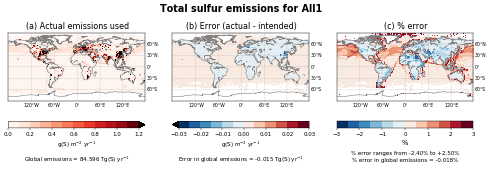

In [11]:
# Scenario All1 (and Correct1)
scenario = 'Hist_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended (Correct1) global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (All1) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Draw maps
bug_maps_emissions(intended, actual,
                   suptitle='Total sulfur emissions for All1',
                   units=r'g(S) m$^{-2}$ yr$^{-1}$',
                   vmins=(0, -0.03, -3), vmaxs=(1.2, 0.03, 3), nlevs=(12, 12, 12),
                   fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

Notes for **All1**:
- Over **land**, the bug generally leads to a slight **decrease** in sulfur emissions due to missing primary sulfate emissions from domestic and transport sectors. (Over some locations, a slight increae is possible due to the doubled waste treatment and agricultural waste burning emissions.)
- Over open **ocean**, the bug leads to a slight **increase** in sulfur emissions due to doubled primary sulfate emissions from shipping.
- In any given location, the error in sulfur emissions is **at most 2.5%**, and is normally less than this. The impact of the bug is limitted by the fact that only 2.5% of the sulfur dioxide is emitted as primary sulfate.
- **Globally**, the error is only **-0.018%**.

### All0 sulfur emissions

In [12]:
# Scenario All0
scenario = 'Zero_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Area-weight global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (All0) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Note: maps not drawn because zero error everywhere

Intended global total = 32.718 Tg(S)/yr
Actual (All0) global total = 32.718 Tg(S)/yr
Error (Actual - Intended) = +0.000 Tg(S)/yr
Global % error = +0.000%


Notes for **All0**:
- The bug has **no impact** on All0, because the bug only impacts emissions from some anthropogenic sectors.

### Ship1 sulfur emissions

Intended global total = 38.257 Tg(S)/yr
Actual (Ship1) global total = 38.395 Tg(S)/yr
Error (Actual - Intended) = +0.138 Tg(S)/yr
Global % error = +0.362%
Written fS16.pdf


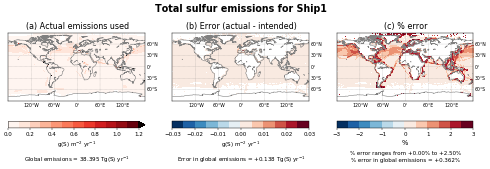

In [13]:
# Scenario Ship1
scenario = 'OnlyShip_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Area-weight global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (Ship1) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Draw maps
bug_maps_emissions(intended, actual,
                   suptitle='Total sulfur emissions for Ship1',
                   units=r'g(S) m$^{-2}$ yr$^{-1}$',
                   vmins=(0, -0.03, -3), vmaxs=(1.2, 0.03, 3), nlevs=(12, 12, 12),
                   fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

Notes for **Ship1**:
- Over **land**, the bug has **no impact**.
- Over **ocean**, the bug leads to a slight **increase** in sulfur emissions, as was the case for All1.
- In any given location, the error in sulfur emissions is **at most 2.5%**, and is normally less than this, as was the case for All1.
- **Globally**, the error is **+0.362%**.

### EAs1 sulfur emissions

Intended global total = 43.484 Tg(S)/yr
Actual (EAs1) global total = 43.435 Tg(S)/yr
Error (Actual - Intended) = -0.048 Tg(S)/yr
Global % error = -0.111%
Written fS17.pdf


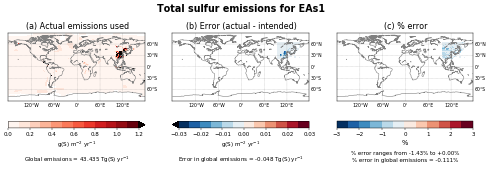

In [14]:
# Scenario EAs1
scenario = 'OnlyEAs_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Area-weight global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (EAs1) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Draw maps
bug_maps_emissions(intended, actual,
                   suptitle='Total sulfur emissions for EAs1',
                   units=r'g(S) m$^{-2}$ yr$^{-1}$',
                   vmins=(0, -0.03, -3), vmaxs=(1.2, 0.03, 3), nlevs=(12, 12, 12),
                   fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

Notes for **EAs1**:
- Over **East Asia land** the bug leads to a slight **decrease** in sulfur emissions, as was the case for All1.
- Over **other land** and open **ocean**, the bug has **no impact**.
- In any given location, the error in sulfur emissions is **at most 1.43%**, and is normally less than this.
- **Globally**, the error is only **-0.111%**.

Similarly, for other members of the **Θ1 group** (excluding Ship1):
- Over the **specific land region**, the bug should generally lead to a slight **decrease** in sulfur emissions.
- Over **other land** and **ocean**, the bug should have **no impact**.

### Ship0 sulfur emissions

Intended global total = 79.073 Tg(S)/yr
Actual (Ship0) global total = 78.919 Tg(S)/yr
Error (Actual - Intended) = -0.154 Tg(S)/yr
Global % error = -0.195%
Written fS18.pdf


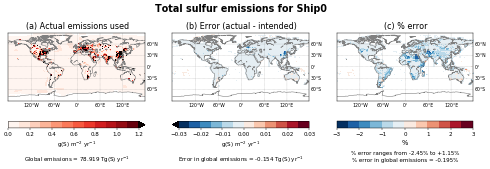

In [15]:
# Scenario Ship1
scenario = 'NoShip_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Area-weight global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (Ship0) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Draw maps
bug_maps_emissions(intended, actual,
                   suptitle='Total sulfur emissions for Ship0',
                   units=r'g(S) m$^{-2}$ yr$^{-1}$',
                   vmins=(0, -0.03, -3), vmaxs=(1.2, 0.03, 3), nlevs=(12, 12, 12),
                   fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

Notes for **Ship0**:
- Over **land** the bug generally leads to a slight **decrease** in sulfur emissions, as was the case for All1.
- Over open **ocean**, the bug has **no impact**.
- In any given location, the error in sulfur emissions is **at most 2.45%**, and is normally less than this.
- **Globally**, the error is only **-0.195%**.

### EAs0 sulfur emissions

Intended global total = 73.846 Tg(S)/yr
Actual (EAs0) global total = 73.879 Tg(S)/yr
Error (Actual - Intended) = +0.033 Tg(S)/yr
Global % error = +0.044%
Written fS19.pdf


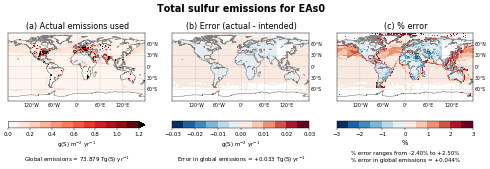

In [16]:
# Scenario EAs0
scenario = 'NoEAs_2000'
# Load emissions for sulfur species
so2_surf = lib_draft2017a.load_emissions('so2', 'surf', scenario=scenario)
so2_elev = lib_draft2017a.load_emissions('so2', 'elev', scenario=scenario)
so4_a1_surf = lib_draft2017a.load_emissions('so4_a1', 'surf', scenario=scenario)  # accumulation mode
so4_a1_elev = lib_draft2017a.load_emissions('so4_a1', 'elev', scenario=scenario)
so4_a2_surf = lib_draft2017a.load_emissions('so4_a2', 'surf', scenario=scenario)  # aitkin mode
so4_a2_elev = lib_draft2017a.load_emissions('so4_a2', 'elev', scenario=scenario)
dms = lib_draft2017a.load_emissions('dms', 'both', scenario=scenario)
# Intended and actual total sulfur emissions
intended = dms + so2_surf + so2_elev + so4_a1_surf + so4_a1_elev + so4_a2_surf + so4_a2_elev
actual = dms + so2_surf + so2_elev + (2 * so4_a1_surf) + so4_a1_elev + so4_a2_elev
# Area-weight global totals
intended_sum = float(climapy.xr_area_weighted_stat(intended, stat='sum')) / 1e12  # Tg(S)/yr
actual_sum = float(climapy.xr_area_weighted_stat(actual, stat='sum')) / 1e12
print('Intended global total = {:.3f} Tg(S)/yr'.format(intended_sum))
print('Actual (EAs0) global total = {:.3f} Tg(S)/yr'.format(actual_sum))
print('Error (Actual - Intended) = {:+.3f} Tg(S)/yr'.format(actual_sum-intended_sum))
print('Global % error = {:+.3%}'.format((actual_sum-intended_sum)/intended_sum))
# Draw maps
bug_maps_emissions(intended, actual,
                   suptitle='Total sulfur emissions for EAs0',
                   units=r'g(S) m$^{-2}$ yr$^{-1}$',
                   vmins=(0, -0.03, -3), vmaxs=(1.2, 0.03, 3), nlevs=(12, 12, 12),
                   fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

Notes for **EAs0**:
- Over **East Asia land**, the bug has **no impact**.
- Over **other land**, the bug generally leads to a slight **decrease** in sulfur emissions, as was the case for All1.
- Over open **ocean**, the bug leads to a slight **increase** in sulfur emissions, as was the case for All1.
- In any given location, the error in sulfur emissions is **at most 2.50%**, and is normally less than this.
- **Globally**, the error is only **+0.044%**.

Similarly, for other members of the **Θ0 group** (excluding Ship0):
- Over the **specific land region**, the bug should have **no impact**.
- Over **other land**, the bug should should lead to a slight **decrease** in sulfur emissions.
- Over open **ocean**, the bug should lead to a slight **increase** in sulfur emissions.

# Impact on results

In [17]:
# Function to produce maps showing impact of bug on All1-All0 results
def bug_maps_output(variable='FSNTOA+LWCF', 
                    vmin=-8, vmax=8, whiteout='0.2', nlev=16,
                    cmap='RdBu_r',
                    fig_filename=None):
    # Get long name, symbol, units etc
    long_name = lib_draft2017a.load_variable_long_dict()[variable]
    symbol = lib_draft2017a.load_variable_symbol_dict()[variable]
    units = lib_draft2017a.load_variable_units_dict()[variable]
    # Colour map
    cmap2 = plt.cm.get_cmap(cmap, nlev)
    if cmap == 'RdBu_r':
        cmap2.set_over([0.03, 0, 0])
        cmap2.set_under([0, 0, 0.03])
    elif cmap == 'Reds':
        cmap2.set_over([0.03, 0, 0])
    # Set-up plot
    fig = plt.figure(figsize=(15, 4.5))
    gs = gridspec.GridSpec(2,  # 2nd row is for colorbar
                           6,  # each map spans two columns
                           height_ratios=[1, 0.1],
                           width_ratios=[1, 1, 1, 1, 1, 1])
    # Loop over subplots
    combinations = ['Correct1-All0', 'All1-All0', 'All1-Correct1']
    titles = ('(a) Correct1 - All0', '(b) All1 - All0', '(c) All1 - Correct1')
    diff_list = []  # list to hold diffs between pairs
    for c, scenario_combination, title in zip(range(3), combinations, titles):
        ax = plt.subplot(gs[0, 2*c:2*c+2])
        # Load 2D stats for scenario combination
        stats_dict = lib_draft2017a.load_2d_stats(scenario_combination=scenario_combination,
                                                  variable=variable)
        diff = stats_dict['mean']
        diff_list.append(diff)
        # Lower bound for first longitude bin (important for map)
        lon = diff['lon']
        lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
        # Pseudo-lower bound for first latitude bin (used for stretching imshow)
        lat = diff['lat']
        lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
        # Set up map
        bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0,
                     llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
        bm.drawcoastlines(color='0.5')
        # Plot difference
        im = ax.imshow(np.ma.masked_inside(diff.values, -1*float(whiteout), float(whiteout)),
                       extent=[lon0, 360+lon0, -lat0, lat0],
                       vmin=vmin, vmax=vmax, cmap=cmap2)
        # Stippling where statistically significant
        p_values = stats_dict['p_value']
        p_fdr = climapy.stats_fdr(p_values, alpha=0.05)  # p-value threshold
        w_sig = np.where(p_values.ravel() <= p_fdr)
        lon_sig, lat_sig = np.meshgrid(lon, lat)
        lon_sig = lon_sig.ravel()[w_sig]
        lat_sig = lat_sig.ravel()[w_sig]
        ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
        # Annotate with p-value threshold
        ax.text(-180, -105, r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
                color='0.5', horizontalalignment='left', verticalalignment='center',
                fontsize='large')
        # Annotate with area-weighted mean
        stats_dict2 = lib_draft2017a.load_regional_stats(
                            scenario_combination=scenario_combination,
                            variable=variable,
                            region='Globe')
        mean_diff = stats_dict2['mean']
        error = stats_dict2['error']
        ax.text(180, -105, 'Mean$={:+.3f}\pm{:.3f}$'.format(mean_diff, error),
                color='k', horizontalalignment='right', verticalalignment='center',
                fontsize='large')
        # Title
        ax.text(0, 95, title, fontsize='x-large',
                horizontalalignment='center', verticalalignment='bottom')
        # Main title
        if title[1] == 'b':
            ax.text(0, 140, '{} ({})'.format(long_name, symbol),
                    fontsize='xx-large', fontweight='bold',
                    horizontalalignment='center', verticalalignment='bottom')
    # Colour bar
    ticks = np.arange(vmin, vmax+1e-10, (vmax-vmin)/(nlev/2))
    extendmin, extendmax, extend = False, False, 'neither'
    diff_max = max([diff.max() for diff in diff_list])
    diff_min = min([diff.min() for diff in diff_list])
    if diff_min < vmin:
        extendmin, extend = True, 'min'
    if diff_max > vmax:
        extendmax, extend = True, 'max'
    if extendmin and extendmax:
        extend = 'both'
    cbar = fig.colorbar(im, cax=plt.subplot(gs[1, 1:5]),
                        ticks=ticks, orientation='horizontal', extend=extend)
    cbar.set_label('{}, {}'.format(symbol, units), fontsize='x-large')
    if whiteout:
        tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
        tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
        cbar.ax.set_xticklabels(tick_labels, fontsize='large')
    # Save figure
    if fig_filename:
        fig.savefig('{}/{}'.format(fig_dir, fig_filename), bbox_inches='tight', dpi=300)
        print('Written {}'.format(fig_filename))
    return fig

# Plot example?
if False:
    fig = bug_maps_output()

### Sulfate aerosol burden

Written fS20.pdf


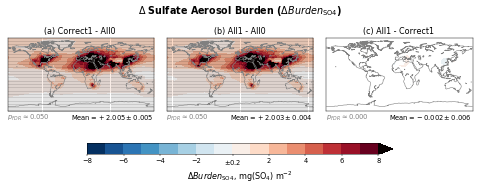

In [18]:
bug_maps_output(variable='BURDENSO4',
                vmin=-8, vmax=8, whiteout='0.2', nlev=16,
                cmap='RdBu_r',
                fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

### Shortwave cloud radiative effect

Written fS21.pdf


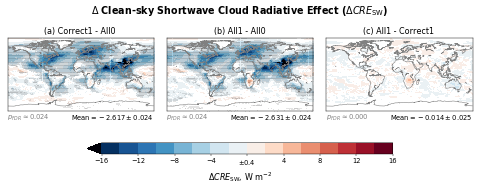

In [19]:
bug_maps_output(variable='SWCF_d1',
                vmin=-16, vmax=16, nlev=16, whiteout='0.4',
                cmap='RdBu_r',
                fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

### Longwave cloud radiative effect

Written fS22.pdf


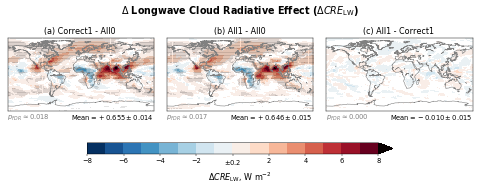

In [20]:
bug_maps_output(variable='LWCF',
                vmin=-8, vmax=8, nlev=16, whiteout='0.2',
                cmap='RdBu_r',
                fig_filename='fS{:02}.pdf'.format(supp_figure_counter))
supp_figure_counter += 1

In [21]:
! date

Wed Aug 15 17:20:36 +08 2018
